In [ ]:
# high level
import jax.numpy as jnp
import numpy as np

#  # Special transform functions
from jax import grad, jit, vmap, pmap
from jax import lax
from jax import make_jaxpr
from jax import random
from jax import device_put

import matplotlib.pyplot as plt

In [ ]:
%%timeit
# Fact 1: JAX's syntax is remarkably similar to NumPy's

# Numpy
x_np = np.linspace(0, 10, 1000)

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
y_np = np.cos(x_np)
plt.plot(x_np, y_np)

plt.subplot(2, 2, 2)
y_np = 2 * np.cos(x_np)
plt.plot(x_np, y_np)

plt.subplot(2, 2, 3)
y_np = np.sin(x_np)
plt.plot(x_np, y_np)

plt.subplot(2, 2, 4)
y_np = 2 * np.sin(x_np)
plt.plot(x_np, y_np)
plt.close()

plt.figure()
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)
plt.close()
# np.max(y_np), np.min(y_np)

135 ms ± 15.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
# Jax
x_jnp = jnp.linspace(0, 10, 1000)

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
y_jnp = jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

plt.subplot(2, 2, 2)
y_jnp = 2 * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

plt.subplot(2, 2, 3)
y_jnp = jnp.sin(x_jnp)
plt.plot(x_jnp, y_jnp)

plt.subplot(2, 2, 4)
y_jnp = 2 * jnp.sin(x_jnp)
plt.plot(x_jnp, y_jnp)
plt.close()

plt.figure()
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)
plt.close()

jnp.max(y_jnp), jnp.min(y_jnp)

237 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Fact 2: JAX arrays are immutable! (embrace the functional programming paradigm <3)

size = 10
index = 0
value = 23

# In NumPy arrays are mutable

x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [ ]:
# In JAX we have to deal with immutable arrays

x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
x = jnp.arange(size)
print(x)

y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [ ]:
# Fact 3: JAX handles random numbers differently (for a good reason! we'll see later why)

seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))
print(type(x))
print(x)

<class 'jaxlib.xla_extension.ArrayImpl'>
[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [ ]:
# import jax
# device = jax.devices()[0]

arr = jnp.arange(10)
arr.devices()

{CpuDevice(id=0)}

In [ ]:
# Fact 3: JAX handles random numbers differently (for a good reason! we'll see later why)

seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))
print(type(x))
print(x, x.devices())

<class 'jaxlib.xla_extension.ArrayImpl'>
[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ] {CpuDevice(id=0)}


In [ ]:
# Fact 4: JAX is AI accelerator agnostic. Same code runs everywhere!

size = 3000

# Data is automagically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)

x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

print(x_jnp.devices())

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready() # 1) On GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)

# Numpy array directly on jax
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready() # same as 1


# Note2: block_until_ready() -> asynchronous dispatch

{CpuDevice(id=0)}
1.01 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
531 ms ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.01 s ± 294 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.07 s ± 300 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
x_np_device

Array([[ 4.9593231e-01,  2.0656219e+00, -1.5399015e-01, ...,
        -2.7450529e-01,  1.1631702e+00,  6.0972214e-01],
       [-2.5526887e-01, -5.8681470e-01, -3.3965206e-01, ...,
         8.5468906e-01,  4.8775721e-01, -1.2907387e+00],
       [-3.6702308e-01, -1.4225066e+00, -6.8058062e-01, ...,
        -1.4996057e+00,  9.2919737e-01, -4.7043714e-01],
       ...,
       [-4.7886831e-01,  6.3019389e-01, -5.2468914e-01, ...,
         1.0215473e+00, -6.0245949e-01, -7.1259767e-01],
       [-5.2742732e-01, -1.8044221e-03,  9.5825171e-01, ...,
         6.1370474e-01,  2.2209961e+00,  5.9476370e-01],
       [-7.7665001e-01,  1.7432488e+00,  1.3749433e+00, ...,
         1.4971533e-01, -6.3602634e-02, -2.2472820e+00]], dtype=float32)

# JAX transform functions

# jit()


jit compiles your functions using XLA and caches them -> speeeeed 🚀


In [ ]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y)
    plt.show()

In [ ]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

In [ ]:
selu_jit = jit(selu)

In [ ]:
data = random.normal(key, (1000000,))

In [ ]:
print('non-jit version:')
%timeit selu(data).block_until_ready()
print('jit version:')
%timeit selu_jit(data).block_until_ready()

non-jit version:
3.48 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
jit version:
1.27 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## grad()

Differentation can be:

* manual
* symbolic
* numeric
* automatic!

In [ ]:
def sum_logistic(x):
    return jnp.sum(1.0/ (1 + jnp.exp(-x)))

In [ ]:
x = jnp.arange(3.)
x

Array([0., 1., 2.], dtype=float32)

In [ ]:
loss = sum_logistic

In [ ]:
# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
# Here we bundled inputs into a 1st param so it doesn't matter.

grad_loss = grad(loss)

print(grad_loss(x))

[0.25       0.19661197 0.10499357]


In [ ]:
for i in jnp.eye(len(x)):
    print(i)

[1. 0. 0.]
[0. 1. 0.]
[0. 0. 1.]


In [ ]:
# Numeric diff (to double check that autodiff works correctly)

def finite_differences(f, x):
    eps = 1e-3
    # 1st iter: f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    # 2nd iter: f(0, 1+e, 2) - f(0, 1-e, 2) / 2e
    # ...
    return jnp.array([(f(x +  eps * v)- f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])

print(finite_differences(loss, x))

[0.24998187 0.1965761  0.10502338]


In [ ]:
def sum_squared(x):
    return jnp.sum(x ** 2) # x1*2 + x2*2 + x3*2

x = jnp.arange(3.)
grad_sum_squared = grad(sum_squared)

print(grad_sum_squared(x))

[0. 2. 4.]


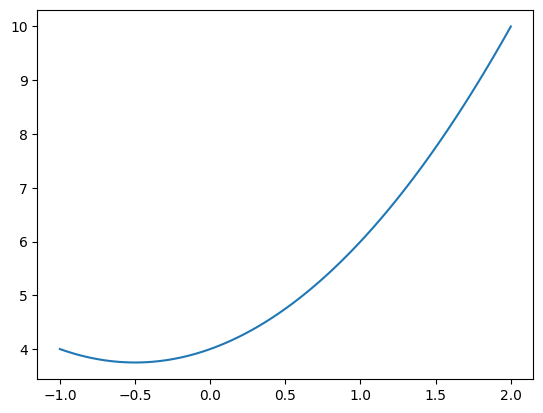

In [ ]:
# Second example (automatic diff)

x = 1.  # example input

f = lambda x: x**2 + x + 4 # simple 2nd order polynomial fn
visualize_fn(f, l=-1, r=2, n=100)

In [ ]:
df_dx = grad(f)
d2f_dx = grad(df_dx)
d3f_dx = grad(d2f_dx)

In [ ]:
print(f(x), df_dx(x), d2f_dx(x), d3f_dx(x))

6.0 3.0 2.0 0.0


In [ ]:
# Second example (automatic diff)

x = 1.  # example input
y = 1.

f = lambda x, y: x**2 + x + 4  + y ** 2

df_dx = grad(f, argnums=(0, 1,))
# d2f_dx = grad(df_dx)
# d3f_dx = grad(d2f_dx)
f(x, y), df_dx(x, y)# , d2f_dx(x), d3f_dx(x)

(7.0,
 (Array(3., dtype=float32, weak_type=True),
  Array(2., dtype=float32, weak_type=True)))

In [ ]:
# JAX autodiff engine is very powerful ("advanced" example)

from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2  # simple paraboloid (google it...)

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1)))

print(f'Jacobian = {jacrev(f, argnums=(0, 1))(1., 1.)}')
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


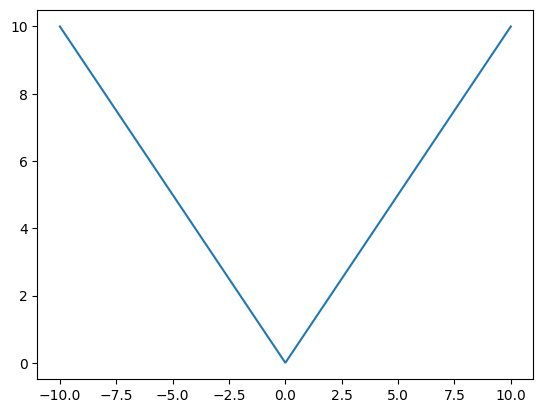

1 1
1.0


In [ ]:
# Edge case |x|, how does JAX handle it?

f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(0.))  # play with numbers around 0 and see how JAX handles it

# vmap() 101
Write your functions as if you were dealing with a single datapoint!

In [ ]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1)

In [ ]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
1.74 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
28 µs ± 6.27 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x, ):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
31.6 µs ± 7.84 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(W, batched_x,):
    return vmap(apply_matrix, in_axes=(None, 0))(batched_x)

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

# Going deeper 🌊

NumPy <-> lax <-> XLA

lax API is stricter and more powerful

It's a Python wrapper around XLA

In [ ]:
# Example 1: lax is stricter

print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion

2.0


ValueError: Cannot lower jaxpr with verifier errors:
	'stablehlo.add' op requires compatible types for all operands and results
		at loc("jit(add)/jit(main)/add"("<ipython-input-39-dab0a0a399fe>":4:0))
	see current operation: %0 = "stablehlo.add"(%arg0, %arg1) : (tensor<i32>, tensor<f32>) -> tensor<i32>
		at loc("jit(add)/jit(main)/add"("<ipython-input-39-dab0a0a399fe>":4:0))
Module string:
#loc1 = loc("args[0]")
#loc2 = loc("args[1]")
"builtin.module"() <{sym_name = "jit_add"}> ({
  "func.func"() <{arg_attrs = [{mhlo.layout_mode = "default", mhlo.sharding = "{replicated}"}, {mhlo.layout_mode = "default", mhlo.sharding = "{replicated}"}], function_type = (tensor<i32>, tensor<f32>) -> tensor<i32>, res_attrs = [{jax.result_info = "", mhlo.layout_mode = "default"}], sym_name = "main", sym_visibility = "public"}> ({
  ^bb0(%arg0: tensor<i32> loc("args[0]"), %arg1: tensor<f32> loc("args[1]")):
    %0 = "stablehlo.add"(%arg0, %arg1) : (tensor<i32>, tensor<f32>) -> tensor<i32> loc(#loc4)
    "func.return"(%0) : (tensor<i32>) -> () loc(#loc)
  }) : () -> () loc(#loc)
}) {mhlo.num_partitions = 1 : i32, mhlo.num_replicas = 1 : i32} : () -> () loc(#loc)
#loc = loc(unknown)
#loc3 = loc("<ipython-input-39-dab0a0a399fe>":4:0)
#loc4 = loc("jit(add)/jit(main)/add"(#loc3))


In [ ]:
x = jnp.array([1, 2, 1])
y = jnp.ones(10)

print(x)
print(y)

[1 2 1]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
x.reshape(1, 1, 3)

Array([[[1, 2, 1]]], dtype=int32)

In [ ]:
y.reshape(1, 1, 10)


Array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], dtype=float32)

In [ ]:
result_1 = jnp.convolve(x, y)
result_1

Array([1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.], dtype=float32)

In [ ]:
# lax API
result_2 = lax.conv_general_dilated(
    x.reshape(1, 1, 3).astype(float),  # note: explicit promotion
    y.reshape(1, 1, 10),
    window_strides=(1,),
    padding=[(len(y) - 1, len(y) - 1)])  # equivalent of padding='full' in NumPy

print(result_2[0][0])

assert np.allclose(result_1, result_2[0][0], atol=1E-6)

# XLA: https://www.tensorflow.org/xla/operation_semantics#convwithgeneralpadding_convolution

[1. 3. 4. 4. 4. 4. 4. 4. 4. 4. 3. 1.]


In [ ]:
result_2

Array([[[1., 3., 4., 4., 4., 4., 4., 4., 4., 4., 3., 1.]]], dtype=float32)

**How does JIT actually work?**

In [ ]:
# Why JIT? -> jitted functions are much faster.

def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

assert np.allclose(norm(X), norm_compiled(X), atol=1E-6)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

8.55 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.58 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Example of a failure: array shapes must be static

def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))

[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [ ]:
print(jit(get_negatives)(x))

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [ ]:
# So how does it work in the background? -> tracing on different levels of abstraction

@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

# Note: any time we get the same shapes and types we just call the compiled fn!

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[ 0.21797767  4.842613   10.895318  ]
Second call:
[2.9319518 6.481262  7.0260262]


In [ ]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [ ]:
# 2nd example of a failure:

@jit
def f(x, neg):  # depends on the value - remember tracer cares about shapes and types!
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at <ipython-input-53-37903a7075e2>:3 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
# Workaround: the "static" arguments

from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23


In [ ]:
# 3rd example of a failure:

# Task: add some print statements! (<expanding mind>)

@jit
def f(x):
    print(x)
    print(x.shape)
    print(jnp.array(x.shape).prod())
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at <ipython-input-55-df163eab3112>:5 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[2] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line <ipython-input-55-df163eab3112>:10 (f)

In [ ]:
# Workaround: using numpy instead of jax.numpy

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

# Gotcha #1: Pure functions

JAX is designed to work only on pure functions!
Pure function? Informal definition:

All the input data is passed through the function parameters, all the results are output through the function results.
A pure function will always return the same result if invoked with the same inputs.

In [ ]:
# Example 1

def impure_print_side_effect(x):
    print("Executing function")  # Violating #1
    return x

# The side-effects appear during the first run
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

NameError: name 'jit' is not defined

In [ ]:
# Example 2

g = 0.

def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

In [ ]:
# Example 3: very important! Haiku/Flax are basically built upon this idea!

def pure_uses_internal_state(x):

    state = dict(even=0, odd=0)
    for i in range(10):
        state['even' if i % 2 == 0 else 'odd'] += x

    return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(5.))

In [ ]:
# Example 4: iterators are a no no!

# lax.fori_loop; similarly for lax.scan, lax.cond, etc.
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i,x: x+array[i], 0))  # expected result 45

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i,x: x+next(iterator), 0))  # unexpected result 0

## Gotcha #2: In-Place Updates


In [ ]:
jax_array = jnp.zeros((3,3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print("original array unchanged:\n", jax_array)
print("updated array:\n", updated_array)

# If this seems wasteful to you, congrats, you did some algorithms/data structures in your life. ;)
# The thing is - inside jit-compiled code, if the input value x of x.at[idx].set(y)
# is not reused, the compiler will optimize the array update to occur in-place!

In [ ]:
# The expresiveness of NumPy is still there!

print("original array:")
jax_array = jnp.ones((5, 6))
print(jax_array)

print("new array post-addition:")
new_jax_array = jax_array.at[::2, 3:].add(7.)
print(new_jax_array)

## Gotcha #3: Out-of-Bounds Indexing
Due to JAX's accelerator agnostic approach JAX had to make a non-error behaviour for out of bounds indexing (similarly to how invalid fp arithmetic results in NaNs and not an exception).

In [ ]:
# NumPy behavior

try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

In [ ]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

## Gotcha #4: Non-array inputs

This is added by design (performance reasons)


In [ ]:
# NumPy

print(np.sum([1, 2, 3]))

In [ ]:
# JAX

try:
    jnp.sum([1, 2, 3])
except TypeError as e:
    print(f"TypeError: {e}")

In [ ]:
# Why? jaxpr to the rescue!

def permissive_sum(x):
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(make_jaxpr(permissive_sum)(x))

## Gotcha #5: random numbers


In [ ]:
# NumPy - PRNG is stateful!

# Let's sample calling the same function twice
print(np.random.random())
print(np.random.random())

np.random.seed(seed)

rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

# Mersenne Twister PRNG is known to have a number of problems (NumPy's imp of PRNG)

In [ ]:
# JAX's random functions can't modify PRNG's state!

key = random.PRNGKey(seed)
print(key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print(random.normal(key, shape=(1,)))
print(key)  # verify that the state hasn't changed

print(random.normal(key, shape=(1,)))  # oops - same results?
print(key)

In [ ]:
# Solution? -> Split every time you need a pseudorandom number.

print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

# Note1: you can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

In [ ]:
# Why this design?
# Well...think...with current design can the code be:
# 1) reproducible?
# 2) parallelizable?
# 3) vectorisable?

np.random.seed(seed)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

# e.g. bar=0.3 baz=0.4 [0.3 + 2*0.4] [0.4 + 2*0.3] -> not reproducible in parallel envs!
def foo(): return bar() + 2 * baz()

print(foo())

# What if we want to parallelize this code? NumPy assumes too much. 2) is violated.

In [ ]:
# NumPy
np.random.seed(seed)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(seed)
print("all at once: ", np.random.uniform(size=3))

# JAX
key = random.PRNGKey(seed)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(seed)
print("all at once: ", random.normal(key, shape=(3,)))

# NumPy violates 3)

## Gotcha #6: Control Flow


In [ ]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3. * x ** 2
    else:
        return -4 * x

x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y); plt.show()

print(grad(f)(2.))  # ok!
print(grad(f)(4.))  # ok!

In [ ]:
# Python control flow + jit() -> problems in paradise.

# "The tradeoff is that with higher levels of abstraction we gain a more general view
# of the Python code (and thus save on re-compilations),
# but we require more constraints on the Python code to complete the trace."

# Example 1: conditioning on value (same function as in the above cell)
# Solution (recall: we already have seen this)
f_jit = jit(f, static_argnums=(0,))
x = 2.

print(make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

In [ ]:
# Example 2: range depends on value again

def f(x, n):
    y = 0.
    for i in range(n):
        y = y + x[i]
    return y

f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2., 3., 4.]), 15)

print(make_jaxpr(f_jit, static_argnums=(1,))(*x))  # notice how for loop gets unrolled
print(f_jit(*x))

# Note: there is a catch - static args should not change a lot!

In [ ]:
# Even "better" (it's less readable) solution is to use low level API
def f_fori(x, n):
    body_fun = lambda i,val: val+x[i]
    return lax.fori_loop(0, n, body_fun, 0.)

f_fori_jit = jit(f_fori)

print(make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

In [ ]:
# Example 3: this is not problematic (it'll only cache a single branch)

def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x / ln_2
    else:
        return x

print(make_jaxpr(log2_if_rank_2)(jnp.array([1, 2, 3])))

## Gotcha #7: NaNs


In [ ]:
jnp.divide(0., 0.)  # the default non-error behavior will simply return a NaN (as usually)

# If you want to debug where the NaNs are coming from, there are multiple ways
# to do that, here is one:
from jax.config import config
config.update("jax_debug_nans", True)

In [ ]:
# JAX enforces single precision! There are simple ways around it though.

x = random.uniform(key, (1000,), dtype=jnp.float64)
print(x.dtype)

# 2

In [ ]:
import numpy as np

import jax
import jax.numpy as jnp

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

In [ ]:
# The goal of this notebook will be to gain the knowledge necessary to build
# complex ML models (such as NNs) and train them in parallel on multiple devices! 💻💻💻⚡⚡⚡

## The Problem of State

JAX ❤️ Pure Functions => JAX "!❤️" State.


In [ ]:

# 1) We've seen in the last notebook/video that impure functions are problematic.

g = 0.  # state

# We're accessing some external state in this function which causes problems
def impure_uses_globals(x):
    return x + g

# JAX captures the value of the global/state during the first run
print(f"First call: {jit(impure_uses_globals)(4.)}")

First call: 4.0


In [ ]:
# Let's update the global/state!
g = 10.

# Subsequent runs may silently use the cached value of the globals/state
print ("Second call: ", jit(impure_uses_globals)(5.))

# expected answer 15.

Second call:  5.0


In [ ]:
# 2) We've also seen this pattern how JAX's PRNG
# (which is not stateful in contrast to NumPy's PRNG) is handling state.

seed = 0
state = jax.random.PRNGKey(seed)

# We input the state, we somehow manipulate it and we return it back.
# The state is not saved internally.

state1, state2 = jax.random.split(state, num=2)# default num=2# recall: key/subkey was the terminology we used

In [ ]:
# Let's now explictly address and understand the problem of state!
# Why?
# Well, NNs love statefulness: model params, optimizer params, BatchNorm, etc.
# and we've seen that JAX seems to have a problem with it.

class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n

    def reset(self):
        """Resets the counter to zero."""
        self.n = 0


counter = Counter()

for _ in range(3):  # works like a charm
    print(counter.count())

1
2
3


In [ ]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):  # oops, it's not working as it's supposed to be
    print(fast_count())

1
1
1


In [ ]:
from jax import make_jaxpr  # let's use jaxpr to understand why this is happening

counter.reset()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


In [ ]:
# Solution:

CounterState = int  # our counter state is implemented as a simple integer

class CounterV2:

    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n+1, but here we separate its role as
        # the output and as the counter state for didactic purposes.
        # (as the output may be some arbitrary function of state in general case)
        return n+1, n+1

    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset()  # notice how reset() now returns state (external vs internal imp)

for _ in range(3):  # works like a charm pre-jit, let's see whether the jit version works
    value, state = counter.count(state)  # looks familiar?
    print(value)

1
2
3


In [ ]:
state = counter.reset()
fast_count = jit(counter.count)

for _ in range(3):  # nice, working as expected!
    value, state = fast_count(state)
    print(value)

1
2
3


In summary we used the following rule to convert a stateful class:

```python
class StatefulClass

    state: State

    def stateful_method(*args, **kwargs) -> Output:
```

into a class of the form:

```python
class StatelessClass

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

Nice - we figured an equivalent way to handle states without introducing the side-effects.

This brings us 1 step closer to building neural networks! 🥳

We still need to find a way to handle gradients when dealing with big NNs.

## Enter PyTree 🌳

Before we start - why are gradients a problem in the first place?

### PyTree basics



In [ ]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2  # + 175B params more (minus 4)

# JAX: .backward() is not that great
# also JAX:
x, y, z, w = [1.]*4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)

# Great now we just need to update our params!
# lr = 0.001
# x -= lr*dfdx
# y -= lr*dfdy
# ... (175B lines later)
# w -= lr*dfdw

# No, no, no.
# We do have a better way.

2.0 2.0 2.0 2.0


No, no, no. We do have a better way!

We want to, more naturally, wrap our params in some more complex data structures like dictionaries, etc.

JAX knows how to deal with these! The answer is called a PyTree.

In [ ]:
# A contrived example for pedagogical purposes
# (if your mind needs to attach some semantics to parse this - treat it as model params)
pytree_example = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in pytree_example:
    leaves = jax.tree_util.tree_leaves(pytree)  # handy little function
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7da06f9d00f0>]   has 3 leaves: [1, 'a', <object object at 0x7da06f9d00f0>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [ ]:
# How do we manipulate PyTrees?

list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, (2, 3), 4],
    "a",
    ["a", "b"],
    # jnp.array(["a", "b"])
]

# Let's see how many leaves they have:
for pytree in list_of_lists:
    leaves = jax.tree_util.tree_leaves(pytree)  # handy little function
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

print(jax.tree,map(lambda x: x * 2, list_of_lists))

{'a': 3}                                      has 1 leaves: [3]
[1, 2, 3]                                     has 3 leaves: [1, 2, 3]
[1, 2]                                        has 2 leaves: [1, 2]
[1, (2, 3), 4]                                has 4 leaves: [1, 2, 3, 4]
'a'                                           has 1 leaves: ['a']
['a', 'b']                                    has 2 leaves: ['a', 'b']
[{'a': 6}, [2, 4, 6], [2, 4], [2, (4, 6), 8], 'aa', ['aa', 'bb']]


In [ ]:
another_list_of_lists = list_of_lists
print(jax.tree,map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, (4, 6), 8], 'aa', ['aa', 'bb']]


In [ ]:
# PyTrees need to have the same structure if we are to apply tree_multimap!
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23])
print(jax.tree,map(lambda x, y: x+y, list_of_lists, another_list_of_lists))

ValueError: List arity mismatch: 7 != 6; list: [{'a': 3}, [1, 2, 3], [1, 2], [1, (2, 3), 4], 'a', ['a', 'b'], [23]].

### Less contrived example: training a toy MLP (multi-layer perceptron) model

In [ ]:
import numpy as np

def init_mlp_params(layer_widths):
    params = []

    # Allocate weights and biases (model parameters)
    # Notice: we're not using JAX's PRNG here - doesn't matter for this simple example

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(
                weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
                biases=np.ones(shape=(n_out,)),
            )
        )
    return params


In [ ]:
# Instantiate a single input - single output, 3 layer (2 hidden layers) deep MLP

params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use tree_map - verify that shapes make sense:
jax.tree,map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [ ]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.0001

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = jax.grad(loss_fn)(params, x, y)

    # Task: analyze grads and make sure it has the same structure as params

    # SGD update
    return jax.tree,map(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )

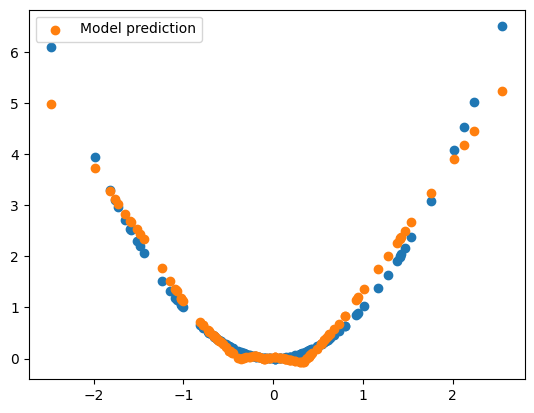

In [ ]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2  # let's learn how to regress a parabola


# Task experiment a bit with other functions (polynomials, sin, etc.)

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)  # again our lovely pattern

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

Wohoo! We've trained our first neural network! 🥳🥳🥳

In order to be able to build NN libs and layers such as nn.Linear (PyTorch syntax), etc. we need a couple more tricks up our sleeves! 🔥

## Custom PyTrees ⚙️


In [ ]:

class MyContainer:  # this could be a linear layer a conv layer or whatever
    """A named container."""
    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c


In [ ]:
example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)]  # 8 leaves? Right? Noup.

leaves = jax.tree_util.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7da06e0f1330>, <__main__.MyContainer object at 0x7da06bf3ed70>]
 has 2 leaves:
 [<__main__.MyContainer object at 0x7da06e0f1330>, <__main__.MyContainer object at 0x7da06bf3ed70>]


In [ ]:
print(jax.tree,map(lambda x: x + 1, example_pytree))  # this will not work :/ it'd be nice if it did


TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'

In [ ]:

# Let's get it to work! We'll need to define 2 functions (flatten/unflatten)

def flatten_MyContainer(container):
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name

    return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

# Register a custom PyTree node
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)


In [ ]:

# Let's try applying tree map again
result = jax.tree,map(lambda x: x + 1, example_pytree)
print(jax.tree_util.tree_leaves(result))  # it works now as expected!


[2, 3, 4, 5, 6, 7]


In [ ]:

# Finally a common gotcha working with PyTrees: mistaking nodes for leaves/children

zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]


In [ ]:
# Try to make another tree with ones instead of zeros
shapes = jax.tree,map(lambda x: x.shape, zeros_tree)  # sol: simply add a jnp.array
print(shapes)


[(2, 3), (3, 4)]


In [ ]:
# shapes is a pytree with 2, 3, 3, 4 as leaf nodes.
# so a ones of shape 2, 3, 3, 4 is created.

ones_tree = jax.tree,map(jnp.ones, shapes)
print(ones_tree)

[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]


In [ ]:
# Fix
shapes = jax.tree,map(lambda x: jnp.array(x.shape), zeros_tree)  # sol: simply add a jnp.array
print(shapes)

ones_tree = jax.tree,map(jnp.ones, shapes)
print(ones_tree)


[Array([2, 3], dtype=int32), Array([3, 4], dtype=int32)]
[Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32), Array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)]


## Parallelism in JAX 💻💻
Parallelism in JAX is handled by another fundamental transform function: pmap

### `pmap` basics


In [ ]:
# Let's try to get ourselves some TPU goodness
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [ ]:
# Let's use a simple running example here
x = np.arange(5)  # signal
w = np.array([2., 3., 4.])  # window/kernel

def convolve(w, x):  # implementation of 1D convolution/correlation
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    return jnp.array(output)

result = convolve(w, x)
print(repr(result))

DeviceArray([11., 20., 29.], dtype=float32)


In [ ]:
n_devices = jax.local_device_count()
print(f'Number of available devices: {n_devices}')

Number of available devices: 8


In [ ]:
# Let's now imagine we have a much heavier load (a batch of examples)
xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

print(xs.shape, ws.shape)


(8, 5) (8, 3)


In [ ]:
# First way to optimize this is to simply use vmap

vmap_result = jax.vmap(convolve)(ws, xs)
print(repr(vmap_result))

DeviceArray([[ 11.,  20.,  29.],
             [ 56.,  65.,  74.],
             [101., 110., 119.],
             [146., 155., 164.],
             [191., 200., 209.],
             [236., 245., 254.],
             [281., 290., 299.],
             [326., 335., 344.]], dtype=float32)


In [ ]:
pmap_result = jax.pmap(convolve)(ws, xs)
print(repr(pmap_result))
print(pmap_result)

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)
[[ 11.  20.  29.]
 [ 56.  65.  74.]
 [101. 110. 119.]
 [146. 155. 164.]
 [191. 200. 209.]
 [236. 245. 254.]
 [281. 290. 299.]
 [326. 335. 344.]]


In [ ]:
# No cross-device communication costs. Computations are done independently on each dev.
double_pmap_result = jax.pmap(convolve)(jax.pmap(convolve)(ws, xs), xs)
print(repr(double_pmap_result))

ShardedDeviceArray([[   78.,   138.,   198.],
                    [ 1188.,  1383.,  1578.],
                    [ 3648.,  3978.,  4308.],
                    [ 7458.,  7923.,  8388.],
                    [12618., 13218., 13818.],
                    [19128., 19863., 20598.],
                    [26988., 27858., 28728.],
                    [36198., 37203., 38208.]], dtype=float32)


In [ ]:
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))

ShardedDeviceArray([[ 11.,  20.,  29.],
                    [ 56.,  65.,  74.],
                    [101., 110., 119.],
                    [146., 155., 164.],
                    [191., 200., 209.],
                    [236., 245., 254.],
                    [281., 290., 299.],
                    [326., 335., 344.]], dtype=float32)


This is all great, but oftentimes we do need to communicate between devices. 📱

Let's see how that is handled.

### Communication between devices 📱📱📱📱

In [ ]:

# Same example as above but this time we communicate across devices
# in order to normalize the outputs
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)  # same result as before

    return output / jax.lax.psum(output, axis_name='batch_dim')  # this is where communication happens

res_pmap = jax.pmap(normalized_convolution, axis_name="batch_dim", in_axes=(None, 0))(w, xs)
res_vmap = jax.vmap(normalized_convolution, axis_name="batch_dim", in_axes=(None, 0))(w, xs)

print(repr(res_pmap))
print(repr(res_vmap))

print(f'Verify the output is normalized: {sum(res_pmap[:, 0])}')

ShardedDeviceArray([[0.00816024, 0.01408451, 0.019437  ],
                    [0.04154303, 0.04577465, 0.04959785],
                    [0.07492582, 0.07746479, 0.07975871],
                    [0.10830861, 0.10915492, 0.10991956],
                    [0.14169139, 0.14084506, 0.14008042],
                    [0.17507419, 0.17253521, 0.17024128],
                    [0.20845698, 0.20422535, 0.20040214],
                    [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
DeviceArray([[0.00816024, 0.01408451, 0.019437  ],
             [0.04154303, 0.04577465, 0.04959785],
             [0.07492582, 0.07746479, 0.07975871],
             [0.10830861, 0.10915492, 0.10991956],
             [0.14169139, 0.14084506, 0.14008042],
             [0.17507419, 0.17253521, 0.17024128],
             [0.20845698, 0.20422535, 0.20040214],
             [0.24183977, 0.23591548, 0.23056298]], dtype=float32)
Verify the output is normalized: 1.0


Great - before we train yet another ML model (this time on multiple devices) let me show you a couple more useful functions!



In [ ]:
def sum_squared_error(x, y):
    return sum((x - y) ** 2)

In [ ]:
x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1

An efficient way to return both grads and loss value

In [ ]:
jax.value_and_grad(sum_squared_error)(x, y)

(DeviceArray(0.03999997, dtype=float32),
 DeviceArray([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32))

And sometimes the loss function needs to return intermediate results

In [ ]:
def sum_squared_error_with_aux(x, y):
    return sum((x-y)**2), x-y

In [ ]:
jax.grad(sum_squared_error_with_aux)(x, y)

TypeError: Gradient only defined for scalar-output functions. Output was (DeviceArray(0.03999997, dtype=float32), DeviceArray([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32)).

In [ ]:
jax.grad(sum_squared_error_with_aux, has_aux=True)(x, y)

(DeviceArray([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32))

We're now ready to see the most complex model pipeline so far in JAX.

### Training a very simple model in parallel!

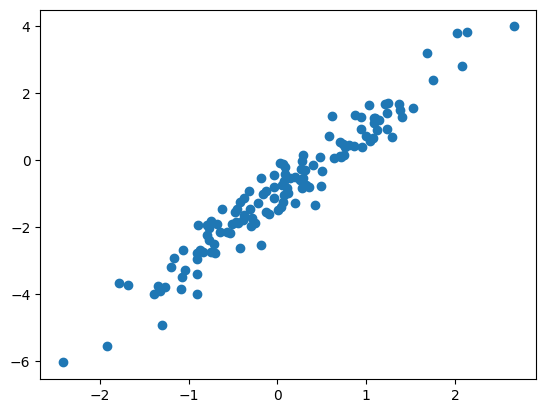

In [ ]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

plt.scatter(xs, ys)
plt.show()

In [ ]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

In [ ]:
lr = 5e-2

In [ ]:
def init_model(rng):
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ()) # single value
    bias = jax.random.normal(bias_key, ()) # single value
    return Params(weight, bias)

In [ ]:
key = jax.random.PRNGKey(0)
jax.random.normal(key, ())

DeviceArray(-0.20584236, dtype=float32)

In [ ]:
def forward(params, xs):
    return params.weight * xs + params.bias

def loss_fn(params, xs, ys):
    pred = forward(params, xs)
    return jnp.mean((pred - ys) ** 2) # MSE

In [ ]:
@functools.partial(jax.pmap, axis_name='batch')
def update(params, xs, ys):

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='batch')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='batch')

    # Each device performs its own SGD update, but since we start with the same params
    # and synchronise gradients, the params stay in sync on each device.
    new_params = jax.tree,map(
        lambda param, g: param - g * lr, params, grads)

    # If we were using Adam or another stateful optimizer,
    # we would also do something like:
    # updates, new_optimizer_state = optimizer(grads, optimizer_state)
    # and then use updates instead of grads to actually update the params.
    # (And we'd include the new_optimizer_state in the output, naturally.)

    return new_params, loss

In [ ]:

# Initialise parameters and replicate across devices.
params = init_model(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree,map(lambda x: jnp.array([x] * n_devices), params)
print(replicated_params)

In [ ]:
# Prepare the data
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

(8, 16, 1) (8, 16, 1)


In [ ]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a {type(obj)}")

In [ ]:
# Actual training loop
num_epochs = 1000
for epoch in range(num_epochs):

    # This is where the params and data gets communicated to devices
    replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

    # replicated_params and loss are now both ShardedDeviceArrays,
    # indicating that they're on the devices.
    # x/y_parallel remains a NumPy array on the host (simulating data streaming).
    if epoch == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_parallel', x_parallel)

    if epoch % 100 == 0:
        print(loss.shape)
        print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree,map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `loss` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `x_parallel` is a <class 'numpy.ndarray'>
(8,)
Step   0, loss: 3.204
(8,)
Step 100, loss: 0.225
(8,)
Step 200, loss: 0.225
(8,)
Step 300, loss: 0.225
(8,)
Step 400, loss: 0.225
(8,)
Step 500, loss: 0.225
(8,)
Step 600, loss: 0.225
(8,)
Step 700, loss: 0.225
(8,)
Step 800, loss: 0.225
(8,)
Step 900, loss: 0.225


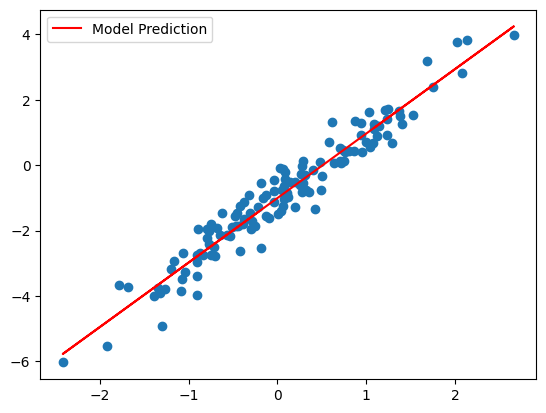

In [ ]:
plt.scatter(xs, ys)
plt.plot(xs, forward(params, xs), c='red', label='Model Prediction')
plt.legend()
plt.show()